<a href="https://colab.research.google.com/github/SullyC25/Week4/blob/main/Interpolation_J3%2BSRAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive; drive.mount('/content/drive', force_remount=False)
%pip -q install numpy pandas xarray netCDF4 h5netcdf scipy pyarrow fastparquet


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.0 MB/s eta 0:00:00


In [ ]:
import os, json, datetime, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import RBFInterpolator
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Paths & basic configurations
BASE = "/content/drive/MyDrive"
COLL = f"{BASE}/CollocationV3"
OUT  = f"{BASE}/InterpolationV2"
FIGS = f"{OUT}/Figures"; VAL = f"{OUT}/Validation"
os.makedirs(OUT, exist_ok=True); os.makedirs(FIGS, exist_ok=True); os.makedirs(VAL, exist_ok=True)

TAG       = "baseline"   # or "relaxed"
PAIR_KIND = "qc"         # "min" (geom/time only) or "qc" (gentle QC)
PAIR_FILE = f"{COLL}/s3_j3_pairs_{TAG}_{PAIR_KIND}.parquet"

# Study domain & target grid
BBOX = (88.0, 93.0, 20.0, 26.0)      # lon_min, lon_max, lat_min, lat_max  (0–360° convention)
GRID_RES = 0.125                     # degrees (matches DUACS 1/8°)
# Interp method: "rbf" (smooth) or "bin" (mean-in-cell)
METHOD = "rbf"

# Bias correction mode: "daily_median" (robust; default) or "global_mean"
BIAS_MODE = "daily_median"

# RBF settings (ignored if METHOD="bin")
RBF_KERNEL = "thin_plate_spline"     # alternatives: "gaussian"
RBF_EPS    = 0.30                    # degrees; ~30 km length scale at these latitudes
RBF_SMOOTH = 0.01                    # smoothing (m^2); tweak 0.0–0.05 to avoid overfit

# Optional light decimation guard for very dense days
MAX_POINTS_PER_DAY = 200_000



In [ ]:
# Record parameters
params = {
    "generated_utc": datetime.datetime.utcnow().isoformat()+"Z",
    "inputs": {"pairs": PAIR_FILE},
    "bbox": BBOX,
    "grid_res_deg": GRID_RES,
    "tag": TAG,
    "pair_kind": PAIR_KIND,
    "method": METHOD,
    "bias_mode": BIAS_MODE,
    "rbf": {"kernel": RBF_KERNEL, "epsilon_deg": RBF_EPS, "smooth_m2": RBF_SMOOTH},
}
with open(f"{OUT}/params_interpolation_v2.json","w") as f: json.dump(params, f, indent=2)
print("Using:", PAIR_FILE)
print("Saving to:", OUT)

Using: /content/drive/MyDrive/CollocationV3/s3_j3_pairs_baseline_qc.parquet
Saving to: /content/drive/MyDrive/InterpolationV2


In [ ]:
# Load pairs & lightly standardize
assert os.path.exists(PAIR_FILE), f"Missing {PAIR_FILE}"
df = pd.read_parquet(PAIR_FILE).copy()

In [ ]:
# Expect CollocationV3 columns
#  - SRAL: time_s3, lon, lat, sla_s3
#  - J3  : j3_time, j3_lon, j3_lat, sla_j3 (plus other *_j3 fields)
need = {"time_s3","lon","lat","sla_s3"}
missing = need - set(df.columns)
assert not missing, f"Pairs file missing columns: {missing}"

df["time_s3"] = pd.to_datetime(df["time_s3"], errors="coerce")
df = df.dropna(subset=["time_s3","lon","lat","sla_s3"]).reset_index(drop=True)

# Box only
lon_min, lon_max, lat_min, lat_max = BBOX
df = df[(df["lon"].between(lon_min, lon_max)) & (df["lat"].between(lat_min, lat_max))].copy()

In [ ]:
#  Bias correction
if BIAS_MODE == "daily_median":
    dte = df["time_s3"].dt.floor("D")
    med = (df.assign(date=dte)
             .groupby("date")
             .apply(lambda g: np.nanmedian((g["sla_s3"] - g.get("sla_j3", np.nan)).to_numpy(dtype="float64")))
             .rename("daily_median_delta")
             .reset_index())
    df = df.merge(med, left_on=df["time_s3"].dt.floor("D"), right_on="date", how="left")
    df["sla_bc"] = df["sla_s3"] - df["daily_median_delta"].astype("float64")
    bias_summary = {
        "mode": "daily_median",
        "N_days": int(med.shape[0]),
        "median_of_medians_m": float(np.nanmedian(med["daily_median_delta"].to_numpy(dtype="float64")))
    }
else:
    delta = (df["sla_s3"] - df.get("sla_j3", np.nan)).astype("float64")
    global_bias = float(np.nanmean(delta))
    df["sla_bc"] = df["sla_s3"] - global_bias
    bias_summary = {"mode": "global_mean", "global_bias_m": global_bias}

pd.DataFrame([bias_summary]).to_csv(f"{OUT}/bias_summary.csv", index=False)
df.to_parquet(f"{OUT}/collocated_biascorrected.parquet", index=False)
print("Bias correction:", bias_summary)


Bias correction: {'mode': 'daily_median', 'N_days': 22, 'median_of_medians_m': -0.032499995082616806}


/tmp/ipython-input-234098879.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nanmedian((g["sla_s3"] - g.get("sla_j3", np.nan)).to_numpy(dtype="float64")))


In [ ]:
#  Target lon-lat grid
LON = np.arange(lon_min, lon_max + GRID_RES, GRID_RES)
LAT = np.arange(lat_min, lat_max + GRID_RES, GRID_RES)
nlon, nlat = len(LON), len(LAT)

def _grid_template(times):
    return xr.Dataset(
        coords=dict(time=("time", times), latitude=("latitude", LAT), longitude=("longitude", LON))
    )


In [ ]:
#  Interpolation methods
def interp_bin_mean(day_df):
    """Simple mean per grid cell for the given day."""
    # compute indices
    i = np.digitize(day_df["lon"].to_numpy(), LON) - 1
    j = np.digitize(day_df["lat"].to_numpy(), LAT) - 1
    m = (i>=0)&(i<nlon-1)&(j>=0)&(j<nlat-1)&np.isfinite(day_df["sla_bc"].to_numpy())
    if not np.any(m):
        return np.full((nlat, nlon), np.nan, dtype="float32")
    # aggregate mean
    key = (j[m]*(nlon-1) + i[m])
    vals = day_df["sla_bc"].to_numpy(dtype="float64")[m]
    dfb = pd.DataFrame({"key": key, "v": vals}).groupby("key")["v"].mean()
    # unpack to grid cell centers
    J = (dfb.index // (nlon-1)).to_numpy()
    I = (dfb.index %  (nlon-1)).to_numpy()
    G = np.full((nlat-1, nlon-1), np.nan, dtype="float32")
    G[J, I] = dfb.values.astype("float32")
    # upscale to full cell-center grid by placing in lower-left of each cell
    out = np.full((nlat, nlon), np.nan, dtype="float32")
    out[:-1, :-1] = G
    return out

def interp_rbf(day_df):
    """RBF interpolation (thin-plate or gaussian) on lon-lat with smoothing."""
    xy = day_df[["lon","lat"]].to_numpy(dtype="float64")
    z  = day_df["sla_bc"].to_numpy(dtype="float64")
    m  = np.isfinite(z) & np.all(np.isfinite(xy), axis=1)
    xy, z = xy[m], z[m]
    if xy.shape[0] < 6:
        return np.full((nlat, nlon), np.nan, dtype="float32")
    if xy.shape[0] > MAX_POINTS_PER_DAY:
        # light, uniform decimation to control memory; preserves spatial coverage
        stride = int(np.ceil(xy.shape[0]/MAX_POINTS_PER_DAY))
        xy = xy[::stride]; z = z[::stride]
    # fit
    rbf = RBFInterpolator(
        xy, z, kernel=("gaussian" if RBF_KERNEL=="gaussian" else "thin_plate_spline"),
        epsilon=RBF_EPS, smoothing=RBF_SMOOTH
    )
    # evaluate on grid
    XX, YY = np.meshgrid(LON, LAT)
    Z = rbf(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
    return Z.astype("float32")

# Choose method
interp_fn = interp_rbf if METHOD == "rbf" else interp_bin_mean


In [ ]:
# Daily loop
df["date"] = df["time_s3"].dt.floor("D")
days = np.sort(df["date"].unique())
print(f"Days to process: {len(days)}")

grids = []
stats_rows = []
for d in days:
    day_df = df.loc[df["date"]==d, ["lon","lat","sla_bc","sla_j3"]].copy()
    # Interpolate SRAL (bias-corrected) to grid
    zi = interp_fn(day_df)

    # Day stats against Jason-3 (pair-level; not gridded)
    if "sla_j3" in day_df.columns:
        x = day_df["sla_bc"].to_numpy(dtype="float64")
        y = day_df["sla_j3"].to_numpy(dtype="float64")
        m = np.isfinite(x) & np.isfinite(y)
        if np.any(m):
            dxy = x[m]-y[m]
            stats_rows.append({
                "date": pd.to_datetime(d),
                "N_pairs": int(np.sum(m)),
                "bias_m": float(np.nanmean(dxy)),
                "rmse_bf_m": float(np.sqrt(np.nanmean((dxy - np.nanmean(dxy))**2))),
                "mad_m": float(np.median(np.abs(dxy - np.median(dxy))))
            })
        else:
            stats_rows.append({"date": pd.to_datetime(d), "N_pairs": 0, "bias_m": np.nan, "rmse_bf_m": np.nan, "mad_m": np.nan})
    else:
        stats_rows.append({"date": pd.to_datetime(d), "N_pairs": np.nan, "bias_m": np.nan, "rmse_bf_m": np.nan, "mad_m": np.nan})

    grids.append(zi)

Days to process: 22


In [ ]:
# Package into xarray and save
if len(grids):
    arr = np.stack(grids, axis=0)   # (time, lat, lon)
    ds_out = _grid_template(pd.to_datetime(days))
    ds_out["sla_s3bc_interp"] = (("time","latitude","longitude"), arr)
    ds_out["sla_s3bc_interp"].attrs.update({
        "long_name": "Sentinel-3 bias-corrected SLA (interpolated)",
        "units": "m", "method": METHOD,
        "bias_mode": BIAS_MODE,
        "rbf_kernel": RBF_KERNEL if METHOD=="rbf" else "",
        "rbf_epsilon_deg": RBF_EPS if METHOD=="rbf" else np.nan,
        "rbf_smoothing_m2": RBF_SMOOTH if METHOD=="rbf" else np.nan
    })
    nc_path = f"{OUT}/s3bc_interpolated_daily_{METHOD}_{TAG}_{PAIR_KIND}.nc"
    ds_out.to_netcdf(nc_path)
    print("Saved NetCDF →", nc_path)

Saved NetCDF → /content/drive/MyDrive/InterpolationV2/s3bc_interpolated_daily_rbf_baseline_qc.nc


In [ ]:
# Save validation + minimal summaries
pd.DataFrame(stats_rows).to_csv(f"{VAL}/daily_pair_stats_{TAG}_{PAIR_KIND}.csv", index=False)

# Quick monthly rollup
stats_df = pd.DataFrame(stats_rows)
if not stats_df.empty:
    stats_df["month"] = pd.to_datetime(stats_df["date"]).dt.to_period("M").astype(str)
    monthly = stats_df.groupby("month").agg(
        N_pairs=("N_pairs","sum"),
        bias_m=("bias_m","mean"),
        rmse_bf_m=("rmse_bf_m","mean"),
        mad_m=("mad_m","mean")
    ).reset_index()
    monthly.to_csv(f"{VAL}/monthly_interp_pair_stats_{TAG}_{PAIR_KIND}.csv", index=False)

print("Done. Artifacts in:", OUT)


Done. Artifacts in: /content/drive/MyDrive/InterpolationV2


In [ ]:
import os, numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path
import importlib

BASE      = globals().get("BASE", "/content/drive/MyDrive")
OUT       = globals().get("OUT", f"{BASE}/InterpolationV2")
COLL      = globals().get("COLL", f"{BASE}/CollocationV3")
PREP      = globals().get("PREP", f"{BASE}/Preprocessing")
FIGS      = globals().get("FIGS", f"{OUT}/Figures")
TAG       = globals().get("TAG", "baseline")
PAIR_KIND = globals().get("PAIR_KIND", "qc")
METHOD    = globals().get("METHOD", "rbf")

os.makedirs(FIGS, exist_ok=True)

# Files
PAIR_FILE = f"{COLL}/s3_j3_pairs_{TAG}_{PAIR_KIND}.parquet"
DS_FILE   = f"{OUT}/s3bc_interpolated_daily_{METHOD}_{TAG}_{PAIR_KIND}.nc"
J3_NC     = f"{PREP}/processed_sla_2024_bangladesh.nc"

# Study box
BBOX = (88.0, 93.0, 20.0, 26.0)

def monsoon_mask(dates):
    d = pd.to_datetime(dates)
    return (d.dt.month >= 7) & (d.dt.month <= 10)

def pick_var(ds, options):
    for k in options:
        if k in ds.variables or k in ds.coords: return k
    low = {k.lower(): k for k in list(ds.variables)+list(ds.coords)}
    for want in options:
        for lk, orig in low.items():
            if want.lower() == lk or want.lower() in lk:
                return orig
    return None

# Load pairs & create bias-corrected column if needed
assert os.path.exists(PAIR_FILE), f"Missing pairs parquet: {PAIR_FILE}"
df = pd.read_parquet(PAIR_FILE).copy()
need = {"time_s3","lon","lat","sla_s3","sla_j3","dist_km","dt_hours"}
missing = need - set(df.columns)
assert not missing, f"Pairs missing {missing}"
df["time_s3"] = pd.to_datetime(df["time_s3"], errors="coerce")
df = df.dropna(subset=["time_s3","lon","lat","sla_s3","sla_j3"]).reset_index(drop=True)

if "sla_bc" not in df.columns:
    dte = df["time_s3"].dt.floor("D")
    med = (df.assign(date=dte)
             .groupby("date")
             .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))
             .rename("daily_median_delta")
             .reset_index())
    df = df.merge(med, left_on=df["time_s3"].dt.floor("D"), right_on="date", how="left")
    df["sla_bc"] = df["sla_s3"] - df["daily_median_delta"].astype("float64")

# Try to open interpolated field & J3 for map figs
ds_interp = xr.open_dataset(DS_FILE) if os.path.exists(DS_FILE) else None
ds_j3     = xr.open_dataset(J3_NC)   if os.path.exists(J3_NC)   else None


/tmp/ipython-input-1825083051.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))


/tmp/ipython-input-3106018319.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))


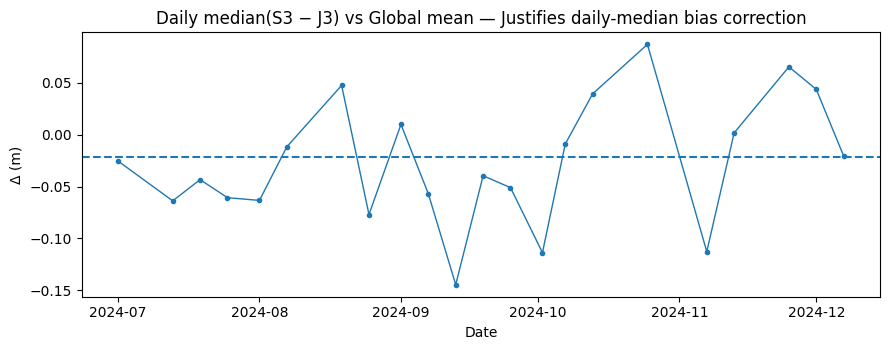

In [ ]:
# FIGURE 1 — Daily bias medians vs global mean
bmed = (df.assign(date=df["time_s3"].dt.floor("D"))
          .groupby("date")
          .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))
          .rename("daily_median_delta")
          .reset_index())
gmean = float((df["sla_s3"] - df["sla_j3"]).astype("float64").mean())

plt.figure(figsize=(9,3.6))
plt.plot(bmed["date"], bmed["daily_median_delta"], marker=".", lw=1)
plt.axhline(gmean, linestyle="--")
plt.title("Daily median(S3 − J3) vs Global mean — Justifies daily-median bias correction")
plt.xlabel("Date"); plt.ylabel("Δ (m)")
plt.tight_layout()
plt.savefig(f"{FIGS}/fig1_daily_bias_median_vs_global.png", dpi=200)
plt.show(); plt.close()


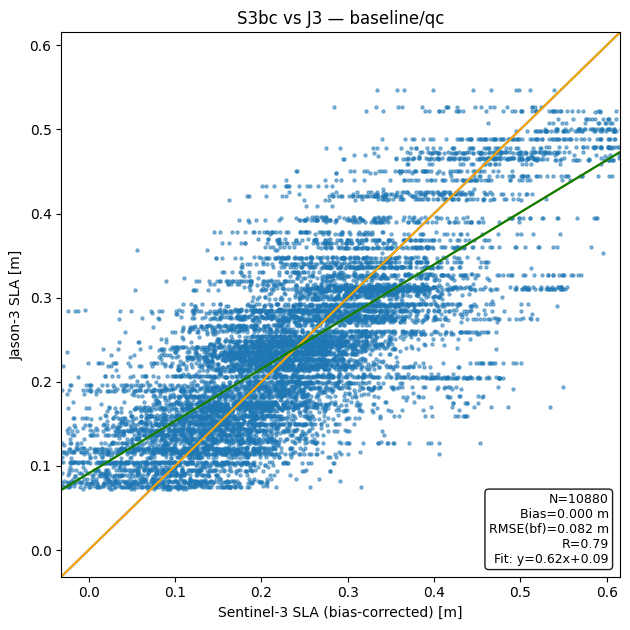

In [ ]:
# FIGURE 2 — Scatter: S3bc vs J3 with stats
x = df["sla_bc"].to_numpy(dtype="float64")
y = df["sla_j3"].to_numpy(dtype="float64")
m = np.isfinite(x) & np.isfinite(y)
xb, yb = x[m], y[m]
d = xb - yb
bias = float(np.mean(d))
rmse_bf = float(np.sqrt(np.mean((d - d.mean())**2)))
R = float(np.corrcoef(xb, yb)[0,1]) if xb.size > 2 else np.nan
slope, intercept = np.polyfit(xb, yb, 1)
lims = np.nanpercentile(np.r_[xb, yb], [1,99])
pad = 0.05*(lims[1]-lims[0]); lo, hi = lims[0]-pad, lims[1]+pad

plt.figure(figsize=(6.4,6.4))
plt.scatter(xb, yb, s=5, alpha=0.5)
plt.plot([lo,hi],[lo,hi])
plt.plot([lo,hi], slope*np.array([lo,hi]) + intercept)
plt.xlabel("Sentinel-3 SLA (bias-corrected) [m]")
plt.ylabel("Jason-3 SLA [m]")
plt.title(f"S3bc vs J3 — {TAG}/{PAIR_KIND}")
txt = f"N={xb.size}\nBias={bias:.3f} m\nRMSE(bf)={rmse_bf:.3f} m\nR={R:.2f}\nFit: y={slope:.2f}x+{intercept:.2f}"
plt.gca().text(0.98,0.02,txt,transform=plt.gca().transAxes,ha="right",va="bottom",
               bbox=dict(boxstyle="round,pad=0.3",fc="white",ec="black",alpha=0.9),fontsize=9)
plt.plot([lo,hi],[lo,hi], color="orange")  # 1:1 line in orange
plt.plot([lo,hi], slope*np.array([lo,hi]) + intercept, color="green")  # fit line in green

plt.xlim(lo,hi); plt.ylim(lo,hi)
plt.tight_layout()
plt.savefig(f"{FIGS}/fig2_scatter_s3bc_vs_j3_{TAG}_{PAIR_KIND}.png", dpi=200)
plt.show(); plt.close()

In [1]:
# FIGURE 3 — RMSE vs distance & vs time gap

def rmse_binned(val, bins, residual):
    centers, rmse, counts = [], [], []
    idx = np.digitize(val, bins) - 1
    for i in range(len(bins)-1):
        msk = (idx==i) & np.isfinite(residual)
        centers.append(0.5*(bins[i]+bins[i+1]))
        counts.append(int(np.sum(msk)))
        if np.any(msk):
            rr = residual[msk]; rmse.append(float(np.sqrt(np.nanmean((rr - np.nanmean(rr))**2))))
        else:
            rmse.append(np.nan)
    return np.array(centers), np.array(rmse), np.array(counts)

resid = (df["sla_bc"] - df["sla_j3"]).to_numpy(dtype="float64")
dist_bins = np.array([0,5,10,15,20,30,50])
time_bins = np.array([0,3,6,12,18,24,36,48])

cx_d, rm_d, n_d = rmse_binned(pd.to_numeric(df["dist_km"], errors="coerce").to_numpy(), dist_bins, resid)
cx_t, rm_t, n_t = rmse_binned(pd.to_numeric(df["dt_hours"], errors="coerce").to_numpy(), time_bins, resid)

fig, ax = plt.subplots(1,2, figsize=(10,3.6), sharey=True)
ax[0].bar(cx_d, rm_d, width=np.diff(dist_bins).min()*0.8)
for cx,rv,nv in zip(cx_d,rm_d,n_d):
    if np.isfinite(rv): ax[0].text(cx, rv, f"n={int(nv)}", ha="center", va="bottom", fontsize=8)
ax[0].set_xlabel("Separation distance [km]"); ax[0].set_ylabel("Bias-free RMSE [m]")
ax[0].set_title("RMSE vs distance")

ax[1].bar(cx_t, rm_t, width=np.diff(time_bins).min()*0.8)
for cx,rv,nv in zip(cx_t,rm_t,n_t):
    if np.isfinite(rv): ax[1].text(cx, rv, f"n={int(nv)}", ha="center", va="bottom", fontsize=8)
ax[1].set_xlabel("Time gap [hours]"); ax[1].set_title("RMSE vs time gap")

plt.suptitle(f"Validation trade-offs — {TAG}/{PAIR_KIND}")
plt.tight_layout()
plt.savefig(f"{FIGS}/fig3_rmse_distance_time_{TAG}_{PAIR_KIND}.png", dpi=200)
plt.show(); plt.close()

NameError: name 'df' is not defined

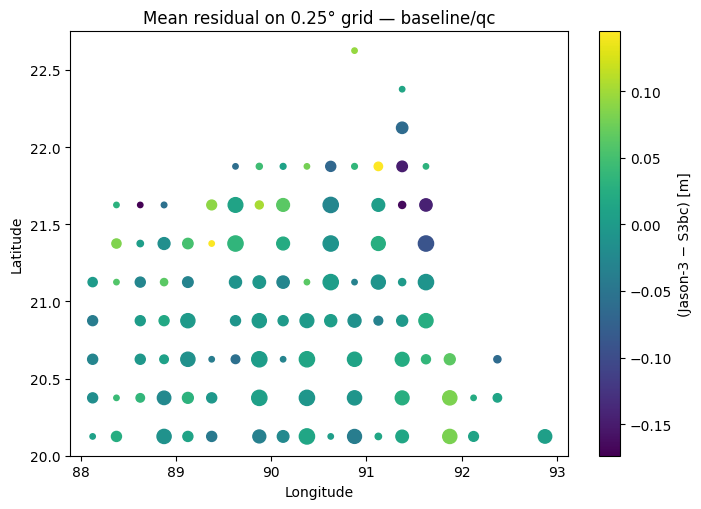

In [ ]:
# FIGURE 4 — 0.25° residual map (J3 − S3bc)

DL = 0.25
xb, xe, yb, ye = BBOX
L = np.arange(xb, xe+DL, DL); M = np.arange(yb, ye+DL, DL)

res = (df["sla_j3"] - df["sla_bc"]).to_numpy(dtype="float64")
i = np.digitize(df["lon"], L) - 1
j = np.digitize(df["lat"], M) - 1
m = (i>=0)&(i<len(L)-1)&(j>=0)&(j<len(M)-1)&np.isfinite(res)
key = i[m]*(len(M)-1)+j[m]
tmp = pd.DataFrame({"key":key, "res":res[m]})
agg = tmp.groupby("key").agg(mean=("res","mean"), N=("res","size")).reset_index()
ii = (agg["key"]//(len(M)-1)).to_numpy(); jj=(agg["key"]%(len(M)-1)).to_numpy()
lonc = L[ii] + DL/2; latc = M[jj] + DL/2

plt.figure(figsize=(7.2,5.2))
sc = plt.scatter(lonc, latc, c=agg["mean"].to_numpy(), s=np.clip(agg["N"].to_numpy()*0.6, 15, 120))
cb = plt.colorbar(sc); cb.set_label("(Jason-3 − S3bc) [m]")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"Mean residual on 0.25° grid — {TAG}/{PAIR_KIND}")
plt.tight_layout()
plt.savefig(f"{FIGS}/fig4_residual_map_0p25_{TAG}_{PAIR_KIND}.png", dpi=200)
plt.show(); plt.close()

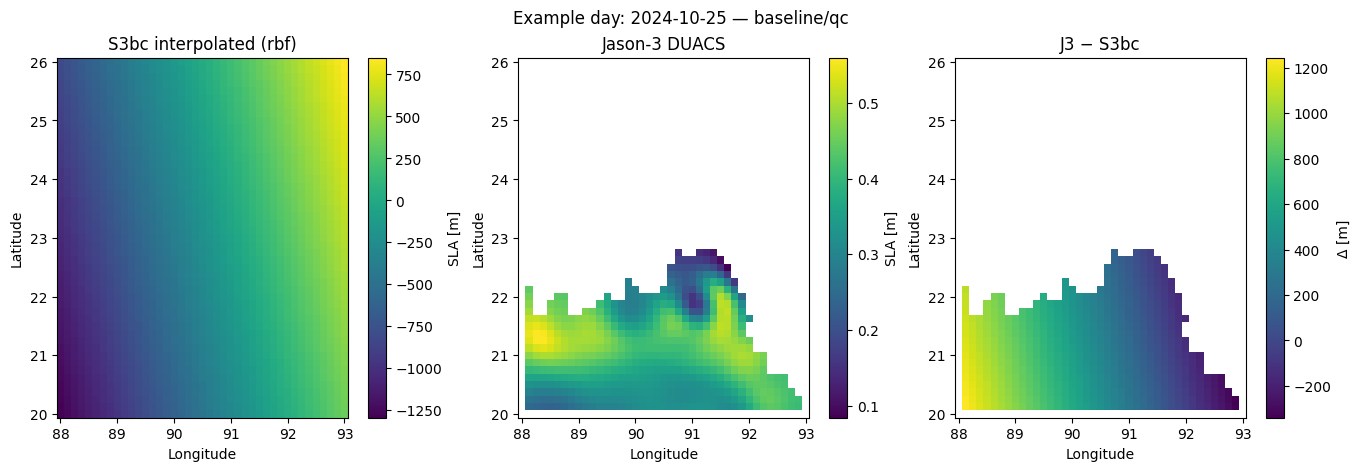

In [ ]:
# FIGURE 5 — Example day maps: S3bc (interp), J3, and Difference
if (ds_interp is not None) and (ds_j3 is not None):
    # day with max pairs
    day_counts = df["time_s3"].dt.floor("D").value_counts().sort_values(ascending=False)
    day0 = pd.to_datetime(day_counts.index[0])

    # nearest in interpolated time
    t_interp = pd.to_datetime(ds_interp["time"].values)
    k = int(np.argmin(np.abs(t_interp - day0)))
    k_date = pd.to_datetime(t_interp[k])

    lon_name = pick_var(ds_j3, ["longitude","lon"])
    lat_name = pick_var(ds_j3, ["latitude","lat"])
    tim_name = pick_var(ds_j3, ["time","utc_time"])
    sla_name = pick_var(ds_j3, ["sla","ssha","sea_level_anomaly","ssh_anomaly"])

    s3map = ds_interp["sla_s3bc_interp"].isel(time=k)  # (lat, lon)
    j3_t = pd.to_datetime(ds_j3[tim_name].values)
    j = int(np.argmin(np.abs(j3_t - k_date)))
    j3 = ds_j3[sla_name].isel({tim_name:j})
    j3 = j3.sel({lat_name: slice(BBOX[2], BBOX[3]),
                 lon_name: slice(BBOX[0], BBOX[1])})
    try:
        j3_on_interp = j3.rename({lat_name:"latitude", lon_name:"longitude"}).interp_like(s3map)
    except Exception:
        j3_on_interp = j3.rename({lat_name:"latitude", lon_name:"longitude"})

    diff = j3_on_interp - s3map

    fig, axs = plt.subplots(1,3, figsize=(13.5,4.6), constrained_layout=True)
    for ax, da, title in zip(
        axs,
        [s3map, j3_on_interp, diff],
        [f"S3bc interpolated ({METHOD})", "Jason-3 DUACS", "J3 − S3bc"]
    ):
        im = ax.pcolormesh(da["longitude"], da["latitude"], da, shading="auto")
        ax.set_title(title)
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        cb = fig.colorbar(im, ax=ax); cb.set_label("SLA [m]" if title!="J3 − S3bc" else "Δ [m]")
    fig.suptitle(f"Example day: {pd.to_datetime(k_date).date()} — {TAG}/{PAIR_KIND}")
    fig.savefig(f"{FIGS}/fig5_example_day_maps_{TAG}_{PAIR_KIND}.png", dpi=200)
    plt.show(); plt.close(fig)
else:
    print("Skip Fig 5: interpolated NetCDF and/or Jason-3 L4 file not found.")


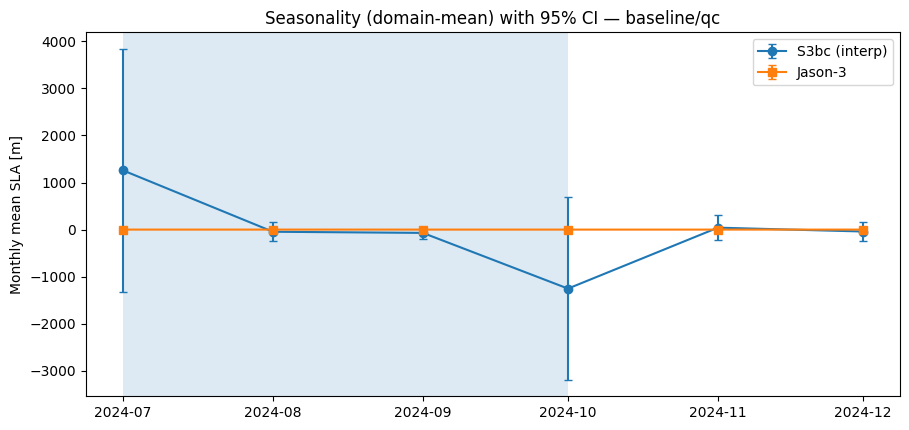

Saved: /content/drive/MyDrive/InterpolationV2/Figures/fig6_seasonality_monthly_ci_baseline_qc.png


In [ ]:
# --- Plot 6: Seasonality — monthly domain-means with 95% CI & monsoon shading ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# helper to find variable names safely
def pick_var(ds, options):
    for k in options:
        if k in ds.variables or k in ds.coords: return k
    low = {k.lower(): k for k in list(ds.variables)+list(ds.coords)}
    for want in options:
        for lk, orig in low.items():
            if want.lower() == lk or want.lower() in lk:
                return orig
    return None

# robust to Series or DatetimeIndex
def monsoon_mask(dates):
    d = pd.to_datetime(dates)
    months = getattr(d, "month", None)  # DatetimeIndex
    if months is None:
        months = d.dt.month             # Series
    return (months >= 7) & (months <= 10)

def monthly_ci(series):
    g = series.groupby(series.index.to_period("M"))
    mean = g.mean()
    std  = g.std()
    n    = g.count().clip(lower=1)
    ci   = 1.96 * std / np.sqrt(n)
    return mean, ci

# assume ds_interp, ds_j3, BBOX, FIGS, TAG, PAIR_KIND already exist
s = ds_interp["sla_s3bc_interp"].mean(("latitude","longitude"), skipna=True).to_pandas()

lon_name = pick_var(ds_j3, ["longitude","lon"])
lat_name = pick_var(ds_j3, ["latitude","lat"])
tim_name = pick_var(ds_j3, ["time","utc_time"])
sla_name = pick_var(ds_j3, ["sla","ssha","sea_level_anomaly","ssh_anomaly"])

j3_box = ds_j3[sla_name].sel({lat_name: slice(BBOX[2], BBOX[3]),
                              lon_name: slice(BBOX[0], BBOX[1])}).mean((lat_name,lon_name), skipna=True)
j = j3_box.to_pandas()

# align by date
s.index = pd.to_datetime(s.index).floor("D")
j.index = pd.to_datetime(j.index).floor("D")
common = s.index.intersection(j.index)
s = s.loc[common]; j = j.loc[common]

# monthly means + 95% CI
s_m, s_ci = monthly_ci(s)
j_m, j_ci = monthly_ci(j)

# monsoon shading (Jul–Oct)
mon = monsoon_mask(s_m.index.to_timestamp())

plt.figure(figsize=(9.2,4.4))
plt.errorbar(s_m.index.to_timestamp(), s_m.values, yerr=s_ci.values, marker="o", capsize=3, label="S3bc (interp)")
plt.errorbar(j_m.index.to_timestamp(), j_m.values, yerr=j_ci.values, marker="s", capsize=3, label="Jason-3")

if np.any(np.asarray(mon)):
    idx = np.where(np.asarray(mon))[0]
    st = idx[0]; prev = idx[0]
    for k in idx[1:]:
        if k != prev+1:
            plt.axvspan(s_m.index.to_timestamp()[st], s_m.index.to_timestamp()[prev], alpha=0.15)
            st = k
        prev = k
    plt.axvspan(s_m.index.to_timestamp()[st], s_m.index.to_timestamp()[prev], alpha=0.15)

plt.ylabel("Monthly mean SLA [m]")
plt.title(f"Seasonality (domain-mean) with 95% CI — {TAG}/{PAIR_KIND}")
plt.legend()
plt.tight_layout()

out_png = f"{FIGS}/fig6_seasonality_monthly_ci_{TAG}_{PAIR_KIND}.png"
plt.savefig(out_png, dpi=200)
plt.show(); plt.close()
print("Saved:", out_png)


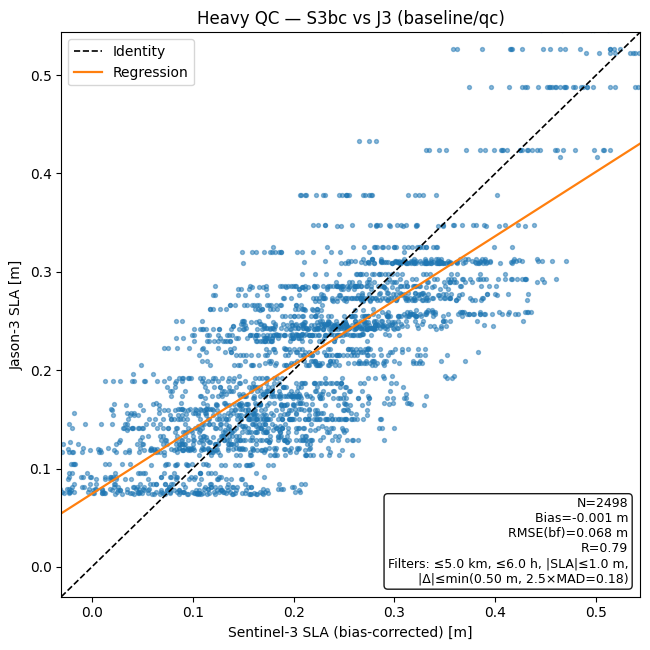

Saved: /content/drive/MyDrive/InterpolationV2/Figures/fig2_scatter_HEAVY_baseline_qc.png


In [ ]:
# --- Heavy-filtered scatter: S3bc vs J3 (strict QC) ---
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Respect existing globals if present
BASE      = globals().get("BASE", "/content/drive/MyDrive")
COLL      = globals().get("COLL", f"{BASE}/CollocationV3")
OUT       = globals().get("OUT",  f"{BASE}/InterpolationV2")
FIGS      = globals().get("FIGS", f"{OUT}/Figures")
TAG       = globals().get("TAG", "baseline")       # or "relaxed"
PAIR_KIND = globals().get("PAIR_KIND", "qc")       # "min" or "qc"
PAIR_FILE = f"{COLL}/s3_j3_pairs_{TAG}_{PAIR_KIND}.parquet"
os.makedirs(FIGS, exist_ok=True)

# Use existing df if available; else load & make sla_bc if needed
if "df" in globals() and {"sla_s3","sla_j3","time_s3","lon","lat"}.issubset(df.columns):
    _df = df.copy()
else:
    _df = pd.read_parquet(PAIR_FILE).copy()
    _df["time_s3"] = pd.to_datetime(_df["time_s3"], errors="coerce")
    if "sla_bc" not in _df.columns:
        med = (_df.assign(date=_df["time_s3"].dt.floor("D"))
                 .groupby("date")
                 .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))
                 .rename("daily_median_delta")
                 .reset_index())
        _df = _df.merge(med, left_on=_df["time_s3"].dt.floor("D"), right_on="date", how="left")
        _df["sla_bc"] = _df["sla_s3"] - _df["daily_median_delta"].astype("float64")

# -------- Heavy QC / trimming --------
MAX_DIST_KM = 5.0
MAX_DT_H    = 6.0
ABS_CAP_M   = 1.0     # |SLA| ≤ 1 m
DELTA_CAP_M = 0.5     # hard cap for |S3bc − J3|, after robust clip threshold

m0 = (
    np.isfinite(_df["sla_bc"]) & np.isfinite(_df["sla_j3"]) &
    (_df["dist_km"] <= MAX_DIST_KM) &
    (_df["dt_hours"] <= MAX_DT_H) &
    _df["sla_bc"].between(-ABS_CAP_M, ABS_CAP_M) &
    _df["sla_j3"].between(-ABS_CAP_M, ABS_CAP_M)
)
df_hard = _df.loc[m0, ["sla_bc","sla_j3","dist_km","dt_hours"]].copy()

# Robust Δ clip with capped threshold
dsl = (df_hard["sla_bc"] - df_hard["sla_j3"]).astype("float64")
mad = float(np.median(np.abs(dsl - np.median(dsl)))) if len(dsl) else 0.0
thr = min(DELTA_CAP_M, 2.5*1.4826*mad) if mad > 0 else DELTA_CAP_M
df_hard = df_hard[np.abs(dsl) <= thr].copy()

# -------- Scatter + stats --------
x = df_hard["sla_bc"].to_numpy(dtype="float64")
y = df_hard["sla_j3"].to_numpy(dtype="float64")
m = np.isfinite(x) & np.isfinite(y)
xb, yb = x[m], y[m]

if xb.size >= 2:
    d = xb - yb
    bias = float(np.mean(d))
    rmse_bf = float(np.sqrt(np.mean((d - np.mean(d))**2)))
    R = float(np.corrcoef(xb, yb)[0,1])
    slope, intercept = np.polyfit(xb, yb, 1)
else:
    bias = rmse_bf = R = slope = intercept = np.nan

lims = np.nanpercentile(np.r_[xb, yb], [1, 99]) if xb.size else (-0.5, 0.5)
pad = 0.05*(lims[1]-lims[0]); lo, hi = lims[0]-pad, lims[1]+pad

plt.figure(figsize=(6.6,6.6))
plt.scatter(xb, yb, s=8, alpha=0.5)
# Distinct line colors (identity=black dashed, regression=orange)
plt.plot([lo, hi], [lo, hi], color="black", ls="--", lw=1.2, label="Identity")
if np.isfinite(slope):
    plt.plot([lo, hi], slope*np.array([lo, hi]) + intercept, color="tab:orange", lw=1.6, label="Regression")

plt.xlabel("Sentinel-3 SLA (bias-corrected) [m]")
plt.ylabel("Jason-3 SLA [m]")
plt.title(f"Heavy QC — S3bc vs J3 ({TAG}/{PAIR_KIND})")

txt = (
    f"N={xb.size}\n"
    f"Bias={bias:.3f} m\nRMSE(bf)={rmse_bf:.3f} m\nR={R:.2f}\n"
    f"Filters: ≤{MAX_DIST_KM} km, ≤{MAX_DT_H} h, |SLA|≤{ABS_CAP_M} m,\n"
    f"|Δ|≤min({DELTA_CAP_M:.2f} m, 2.5×MAD={2.5*1.4826*mad:.2f})"
)
plt.gca().text(0.98, 0.02, txt, transform=plt.gca().transAxes, ha="right", va="bottom",
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9), fontsize=9)

plt.xlim(lo, hi); plt.ylim(lo, hi); plt.legend(loc="upper left"); plt.tight_layout()

out_png = f"{FIGS}/fig2_scatter_HEAVY_{TAG}_{PAIR_KIND}.png"
plt.savefig(out_png, dpi=200)
plt.show(); plt.close()
print("Saved:", out_png)
